## Computer Vision Project 2 - Game of Blackjack
- Kacper Trębacz

- Jan Gruszczyński

# Notebook role:

In the notebook we try to tackle the problem of token detection. We try to use cv2.HughCircles method, but it proves unreliable. Then we try using some binary filters and OSU to maybe detect the tokens with OCRs. Unfortunately this doesn’t work.


In [2]:
import cv2
from IPython.display import display, HTML
import glob
try:
    import Image
except ImportError:
    from PIL import Image
import numpy as np

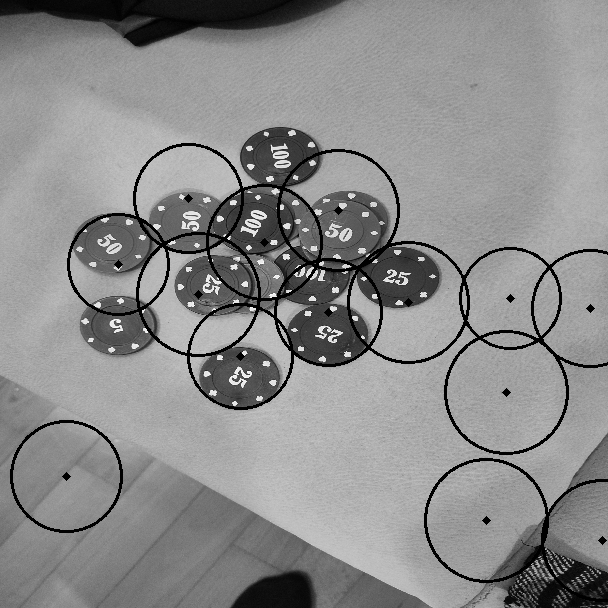

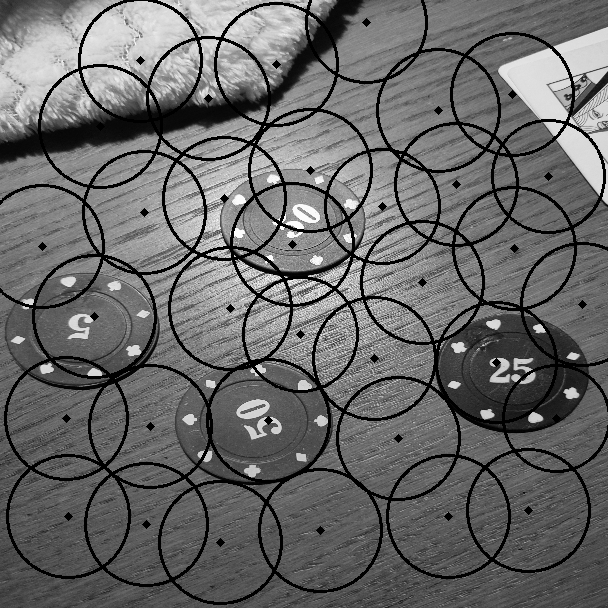

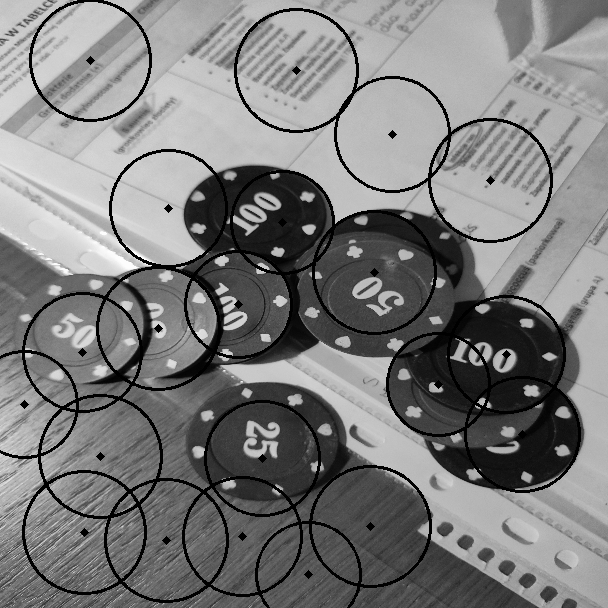

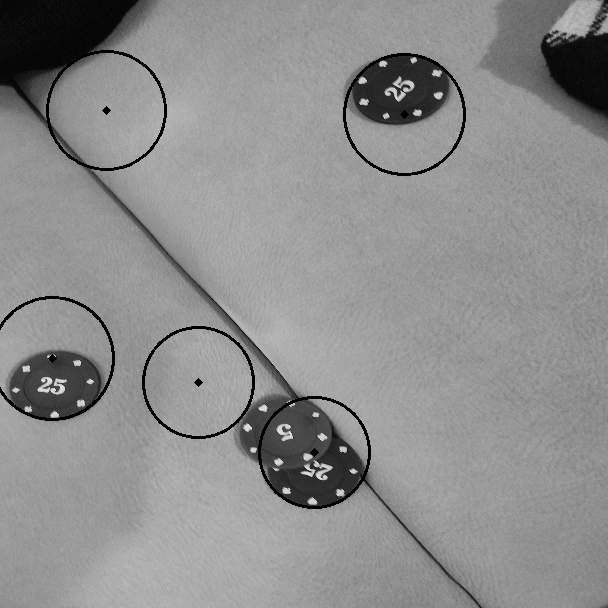

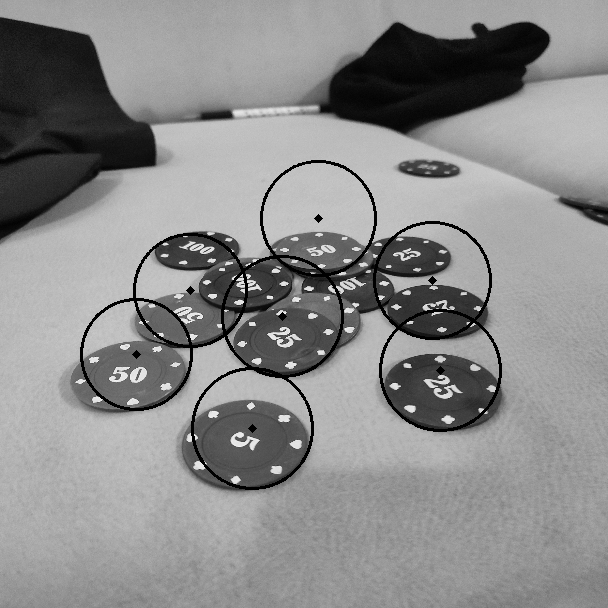

In [17]:
for file in glob.glob('./photos/circles/*.jpg'):
    circle_img = cv2.imread(file, cv2.IMREAD_COLOR)
    circle_img = cv2.cvtColor(circle_img, cv2.COLOR_BGR2GRAY)
    dim = (608, 608)
    circle_img = cv2.resize(circle_img, dim) 
    param = dict(dp=1, minDist=75, param1=75, param2=15, minRadius=50, maxRadius=62)
    
    circles = cv2.HoughCircles(circle_img, cv2.HOUGH_GRADIENT, **param)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))

        for i in circles[0, :]:
            cv2.circle(circle_img,(i[0],i[1]),i[2],(0,255,0),2)
            cv2.circle(circle_img,(i[0],i[1]),2,(0,0,255),3)

    display(Image.fromarray(circle_img))
#     break

In [4]:
import pytesseract

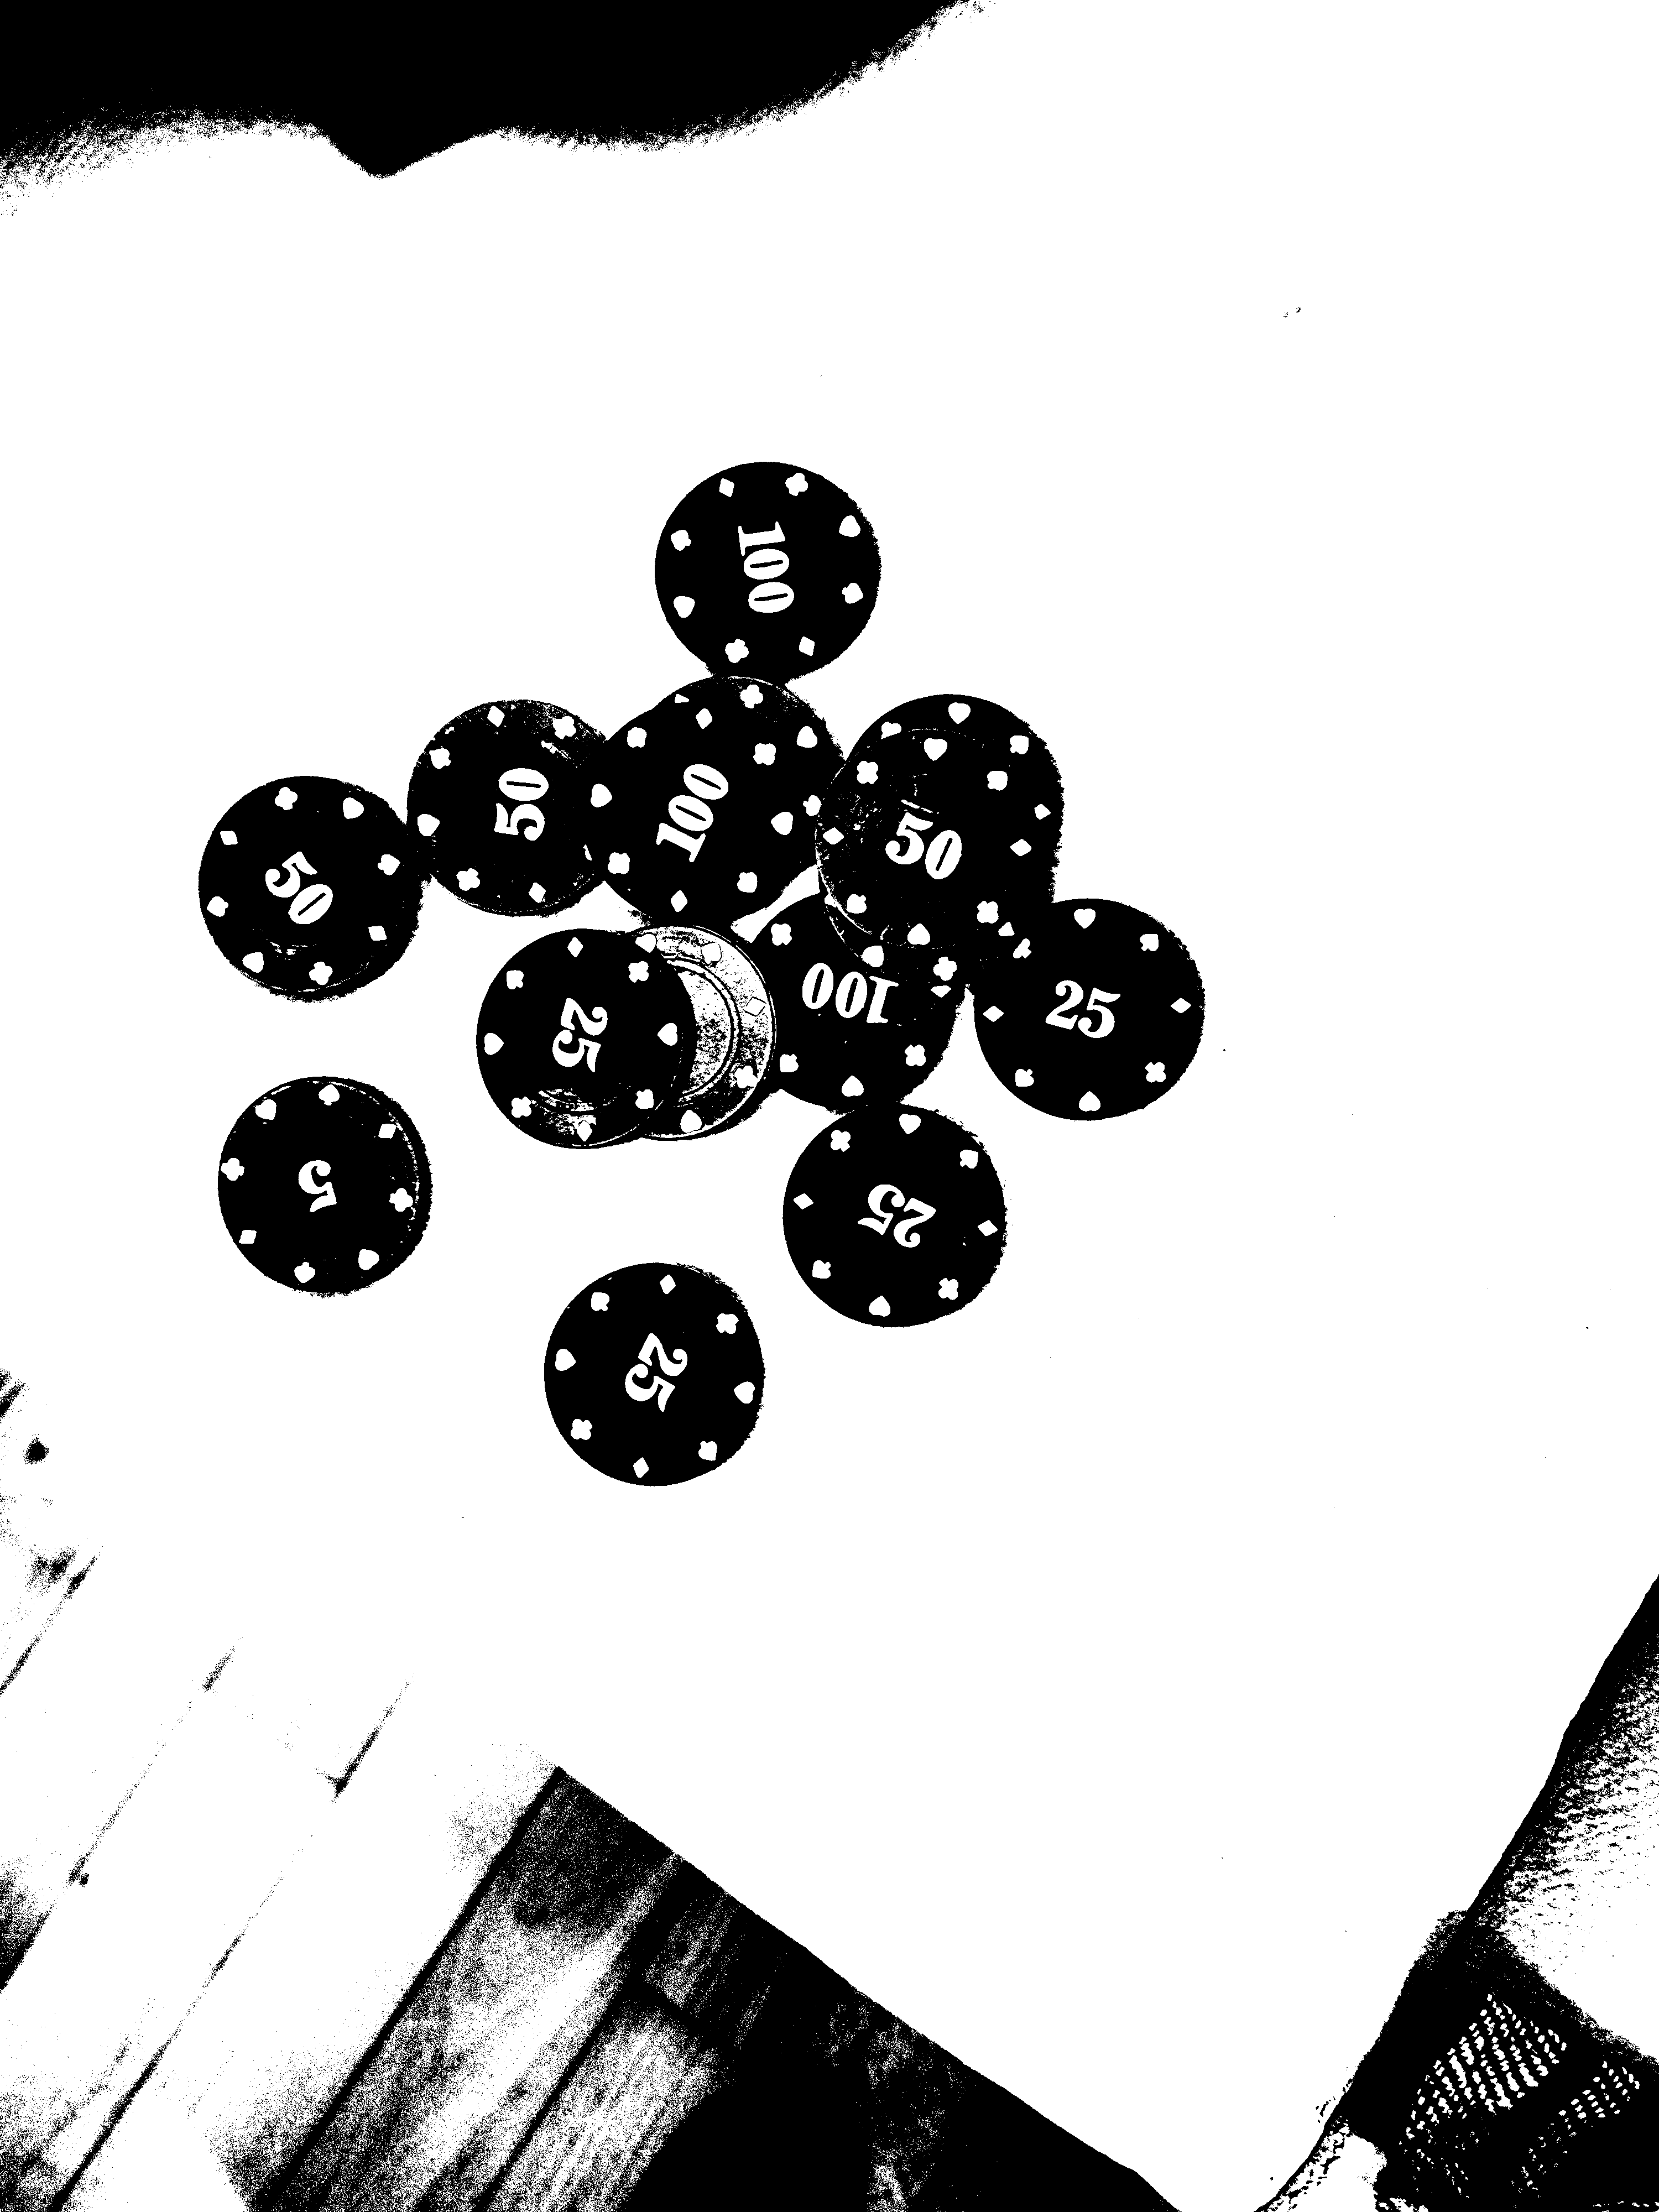

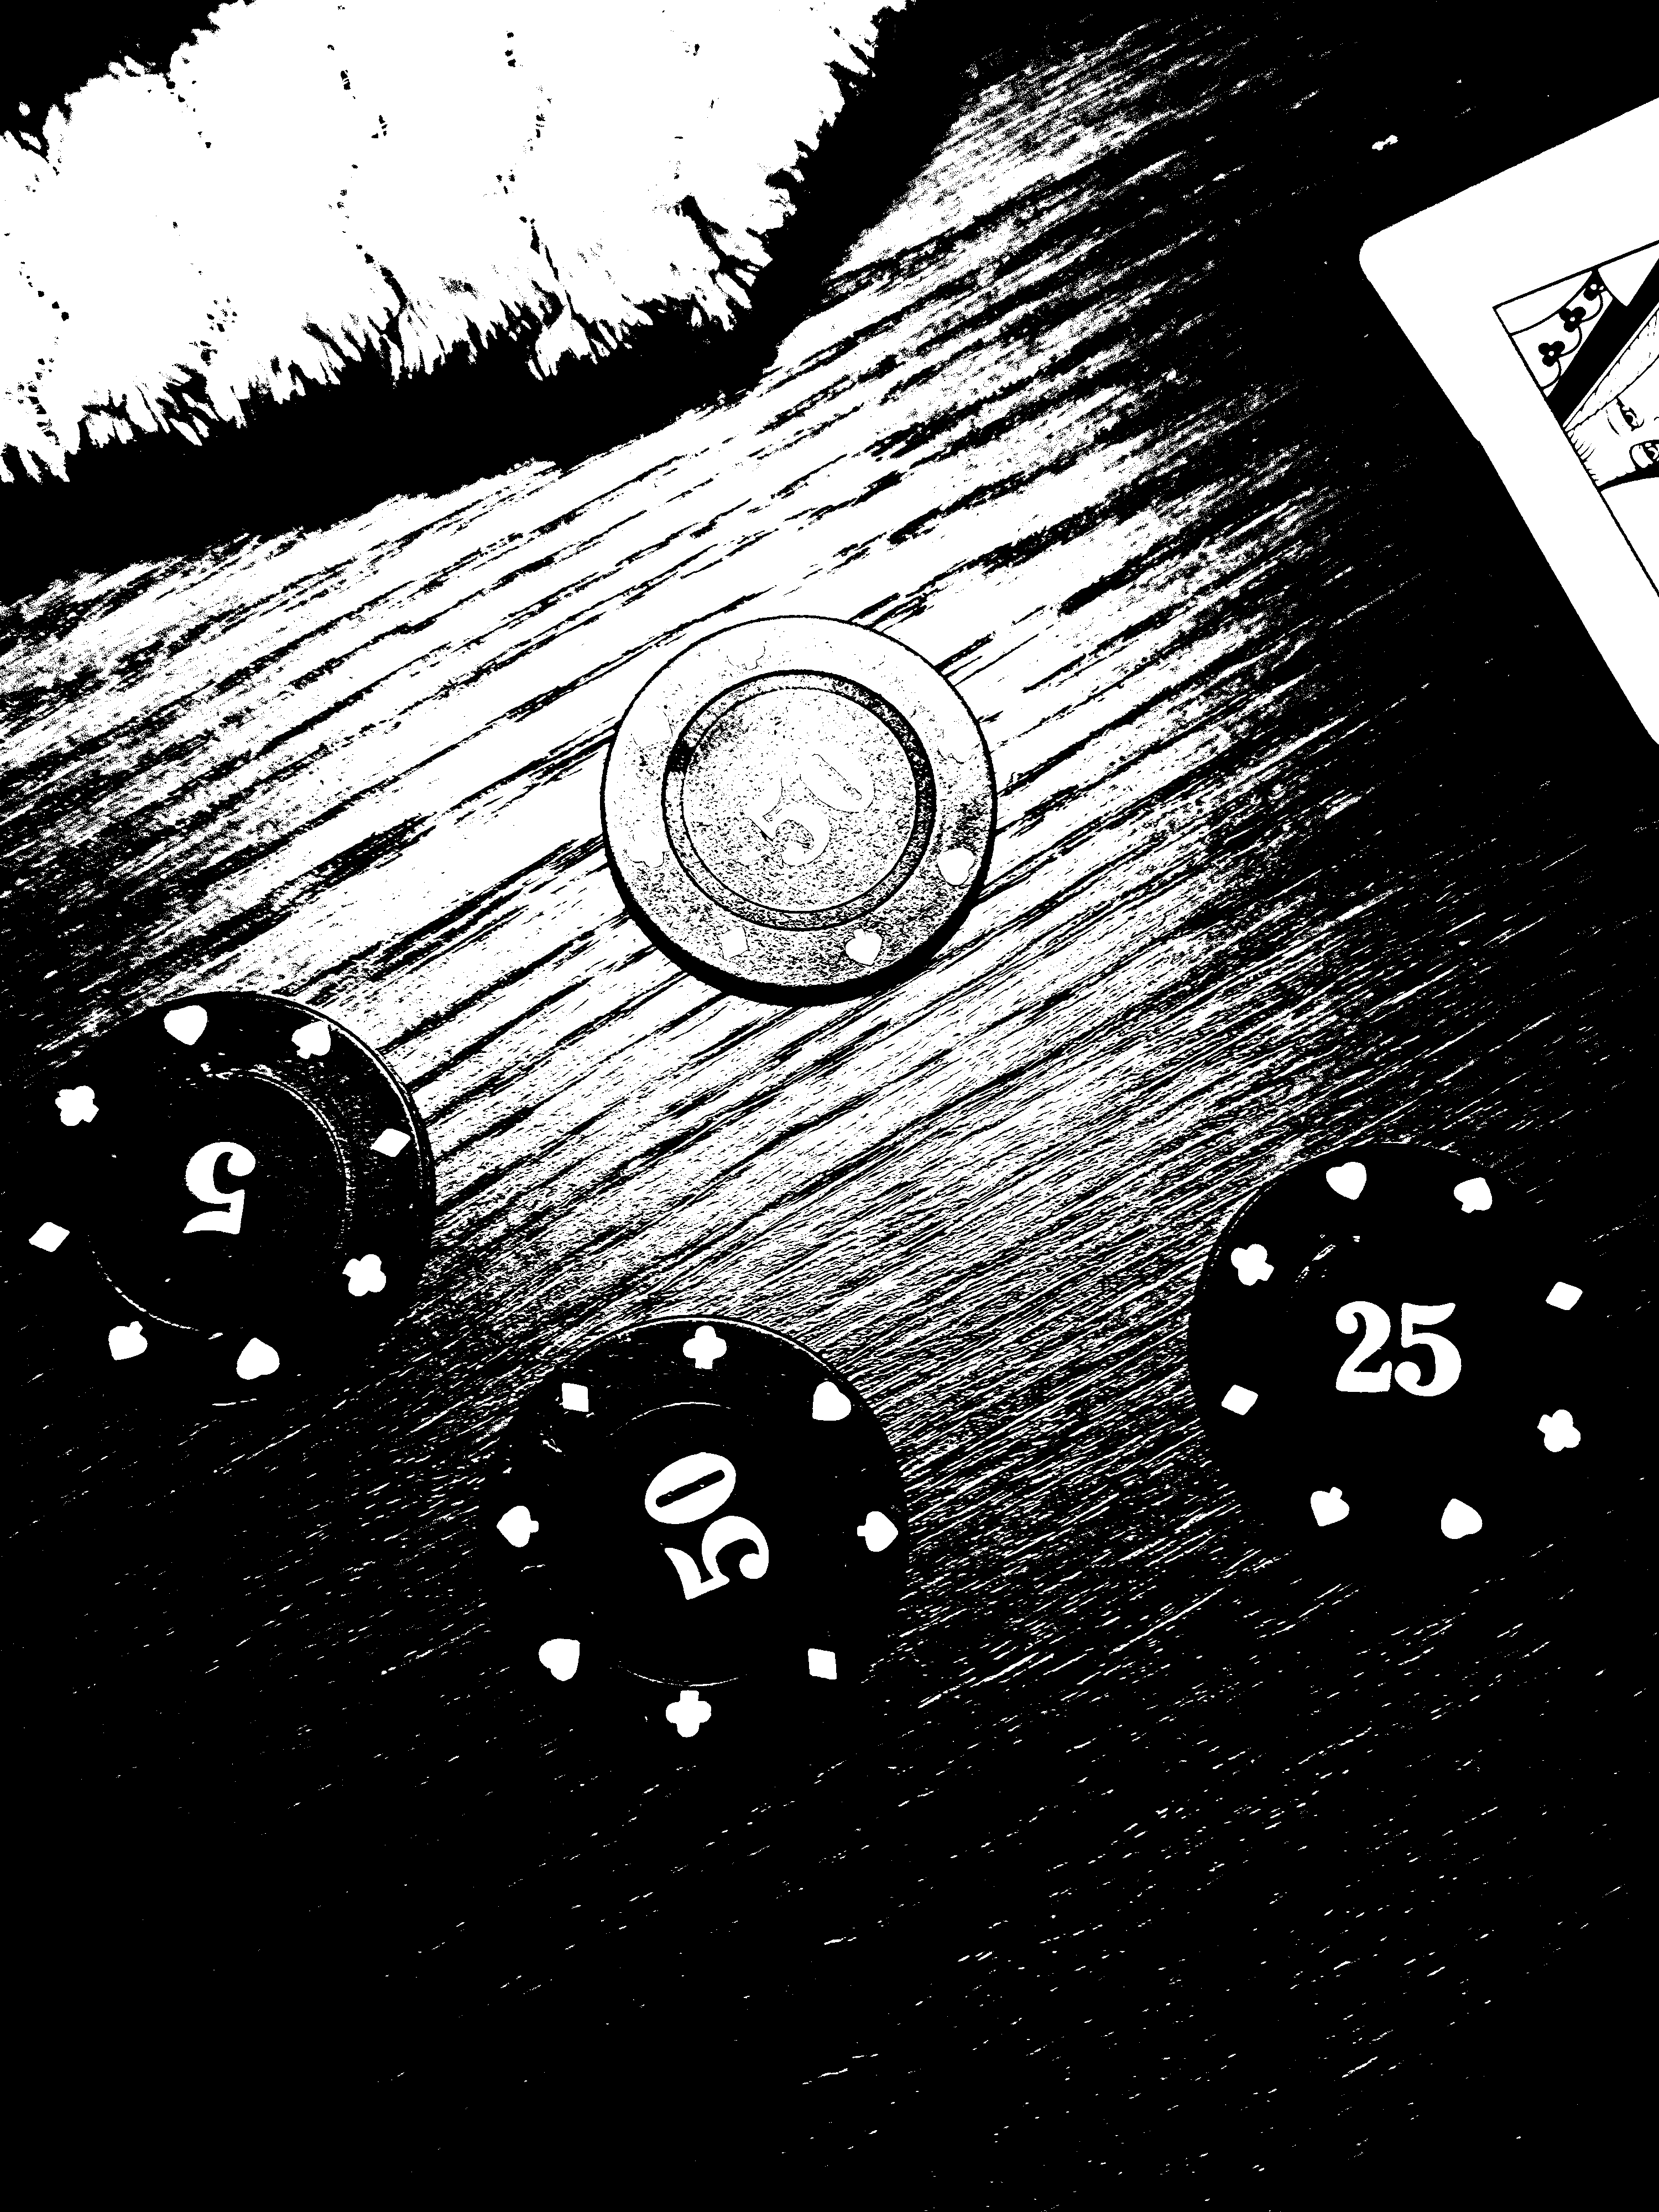

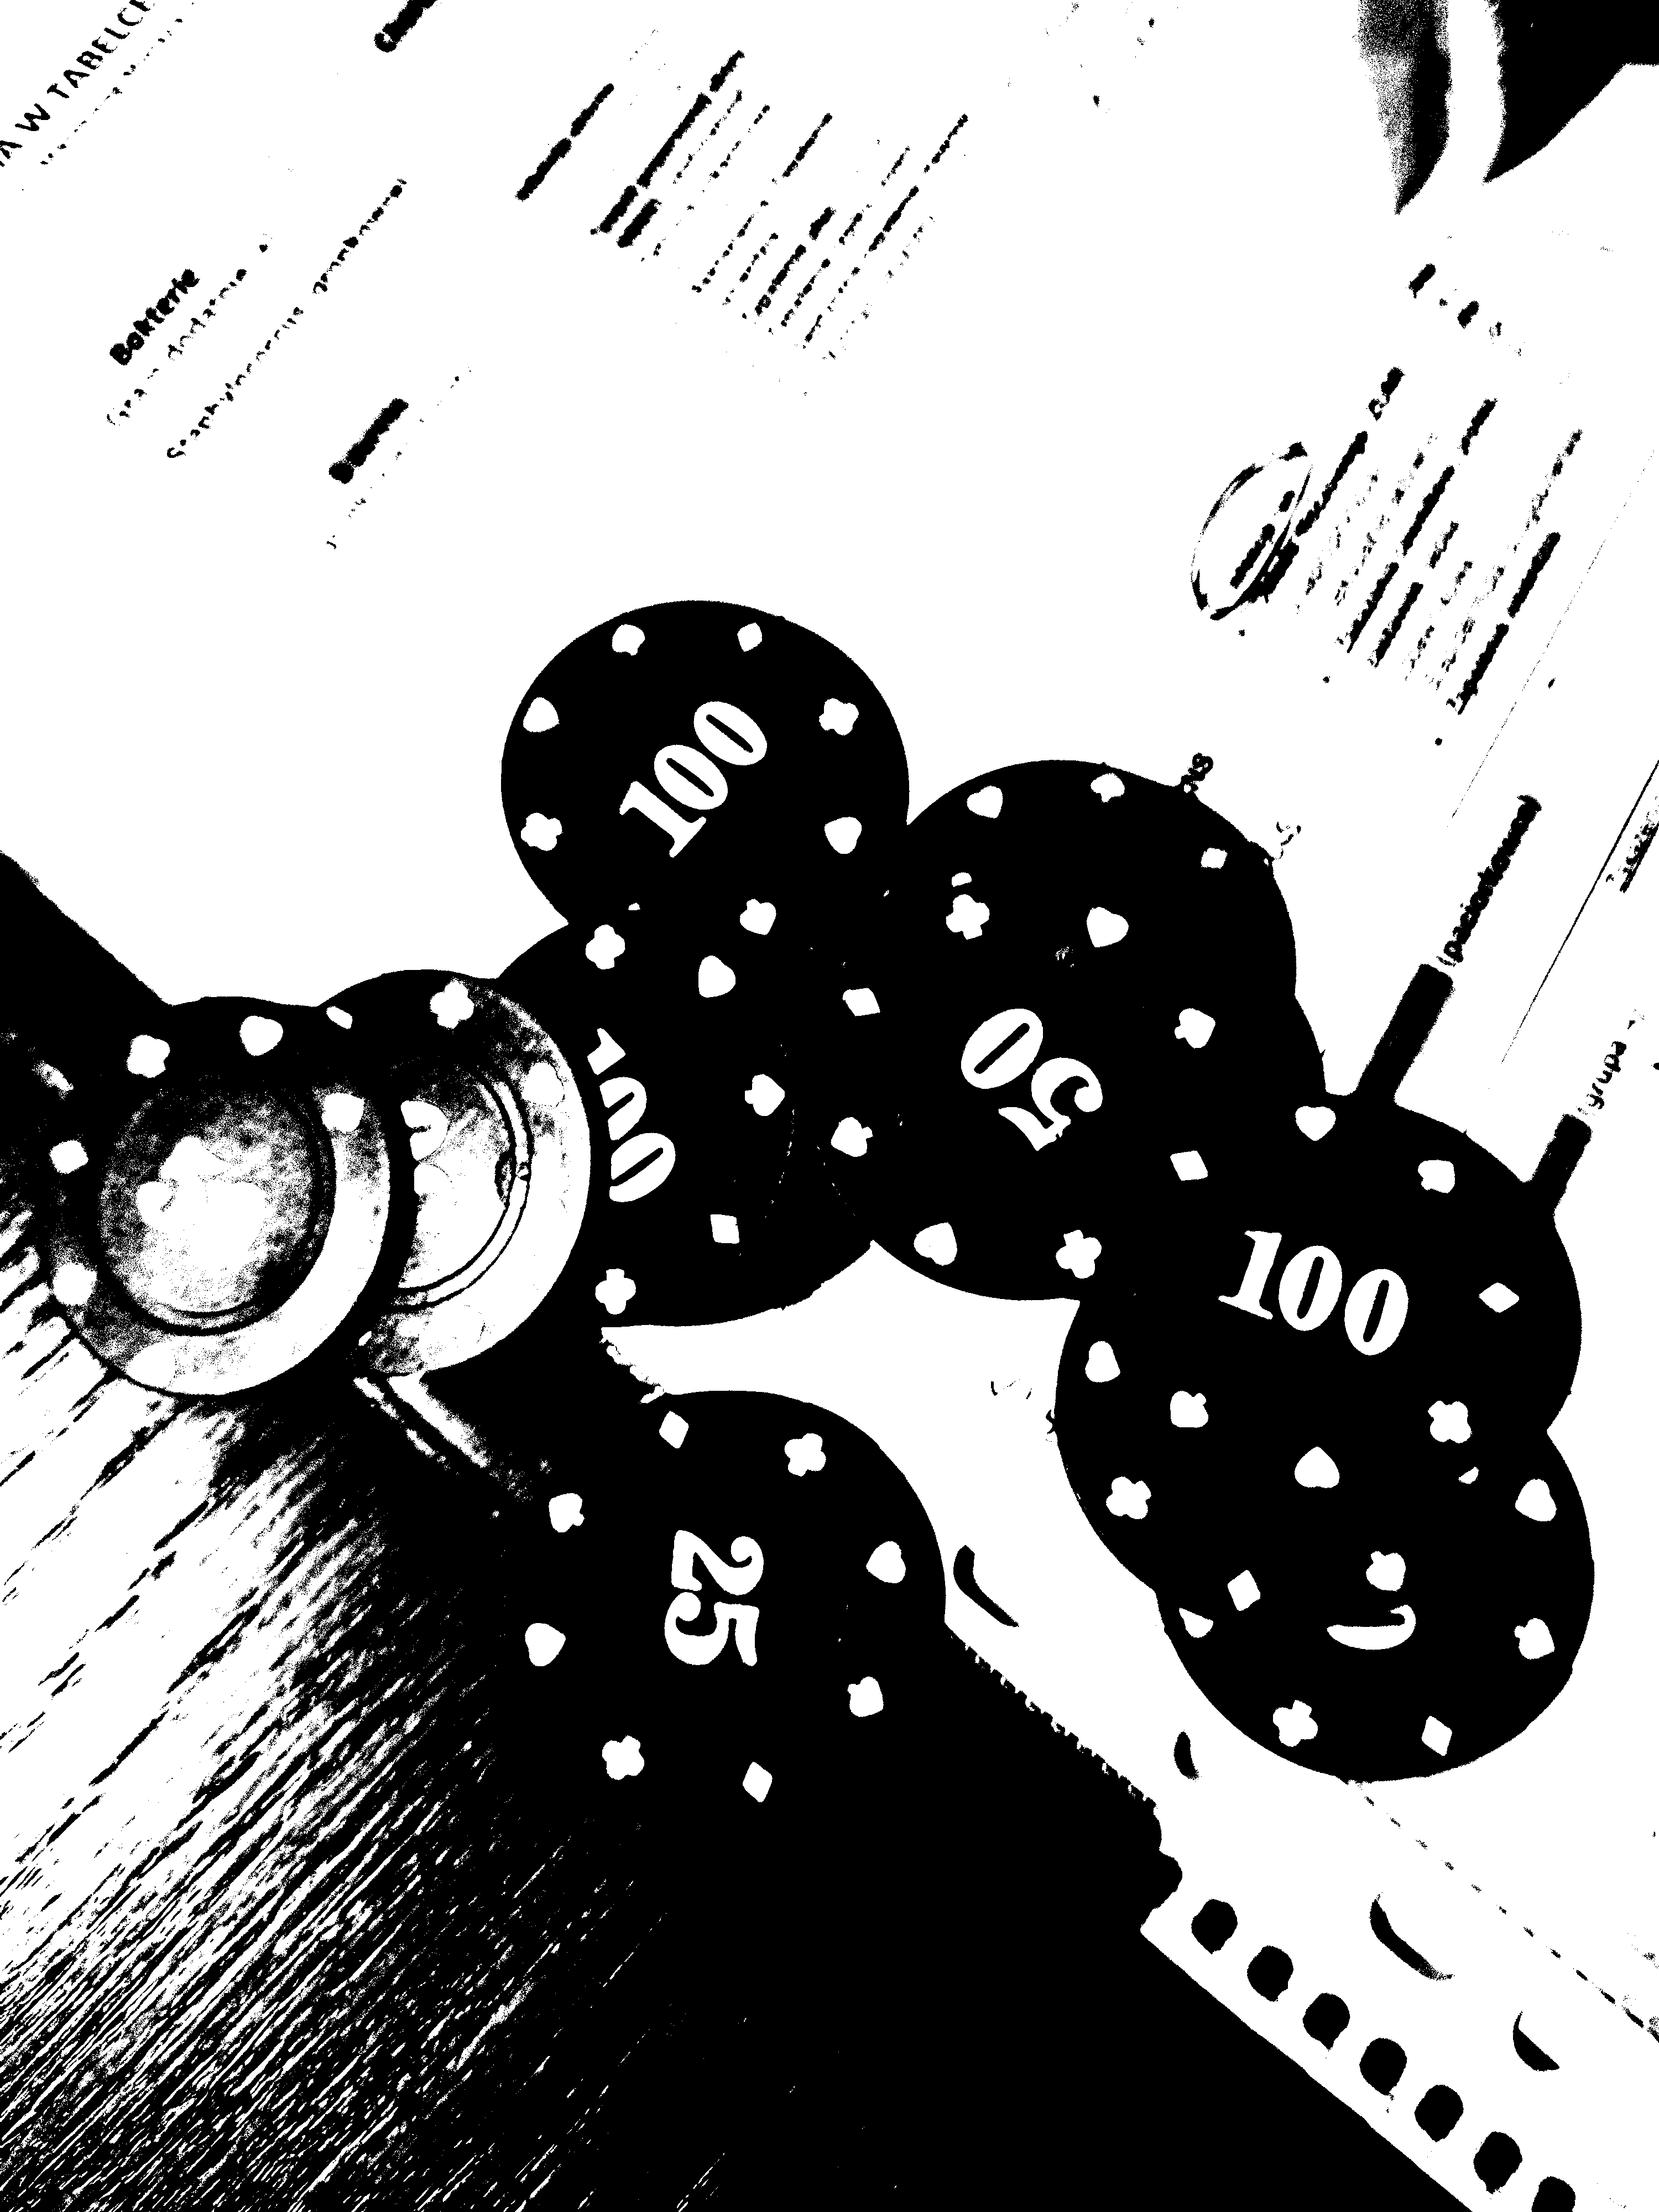

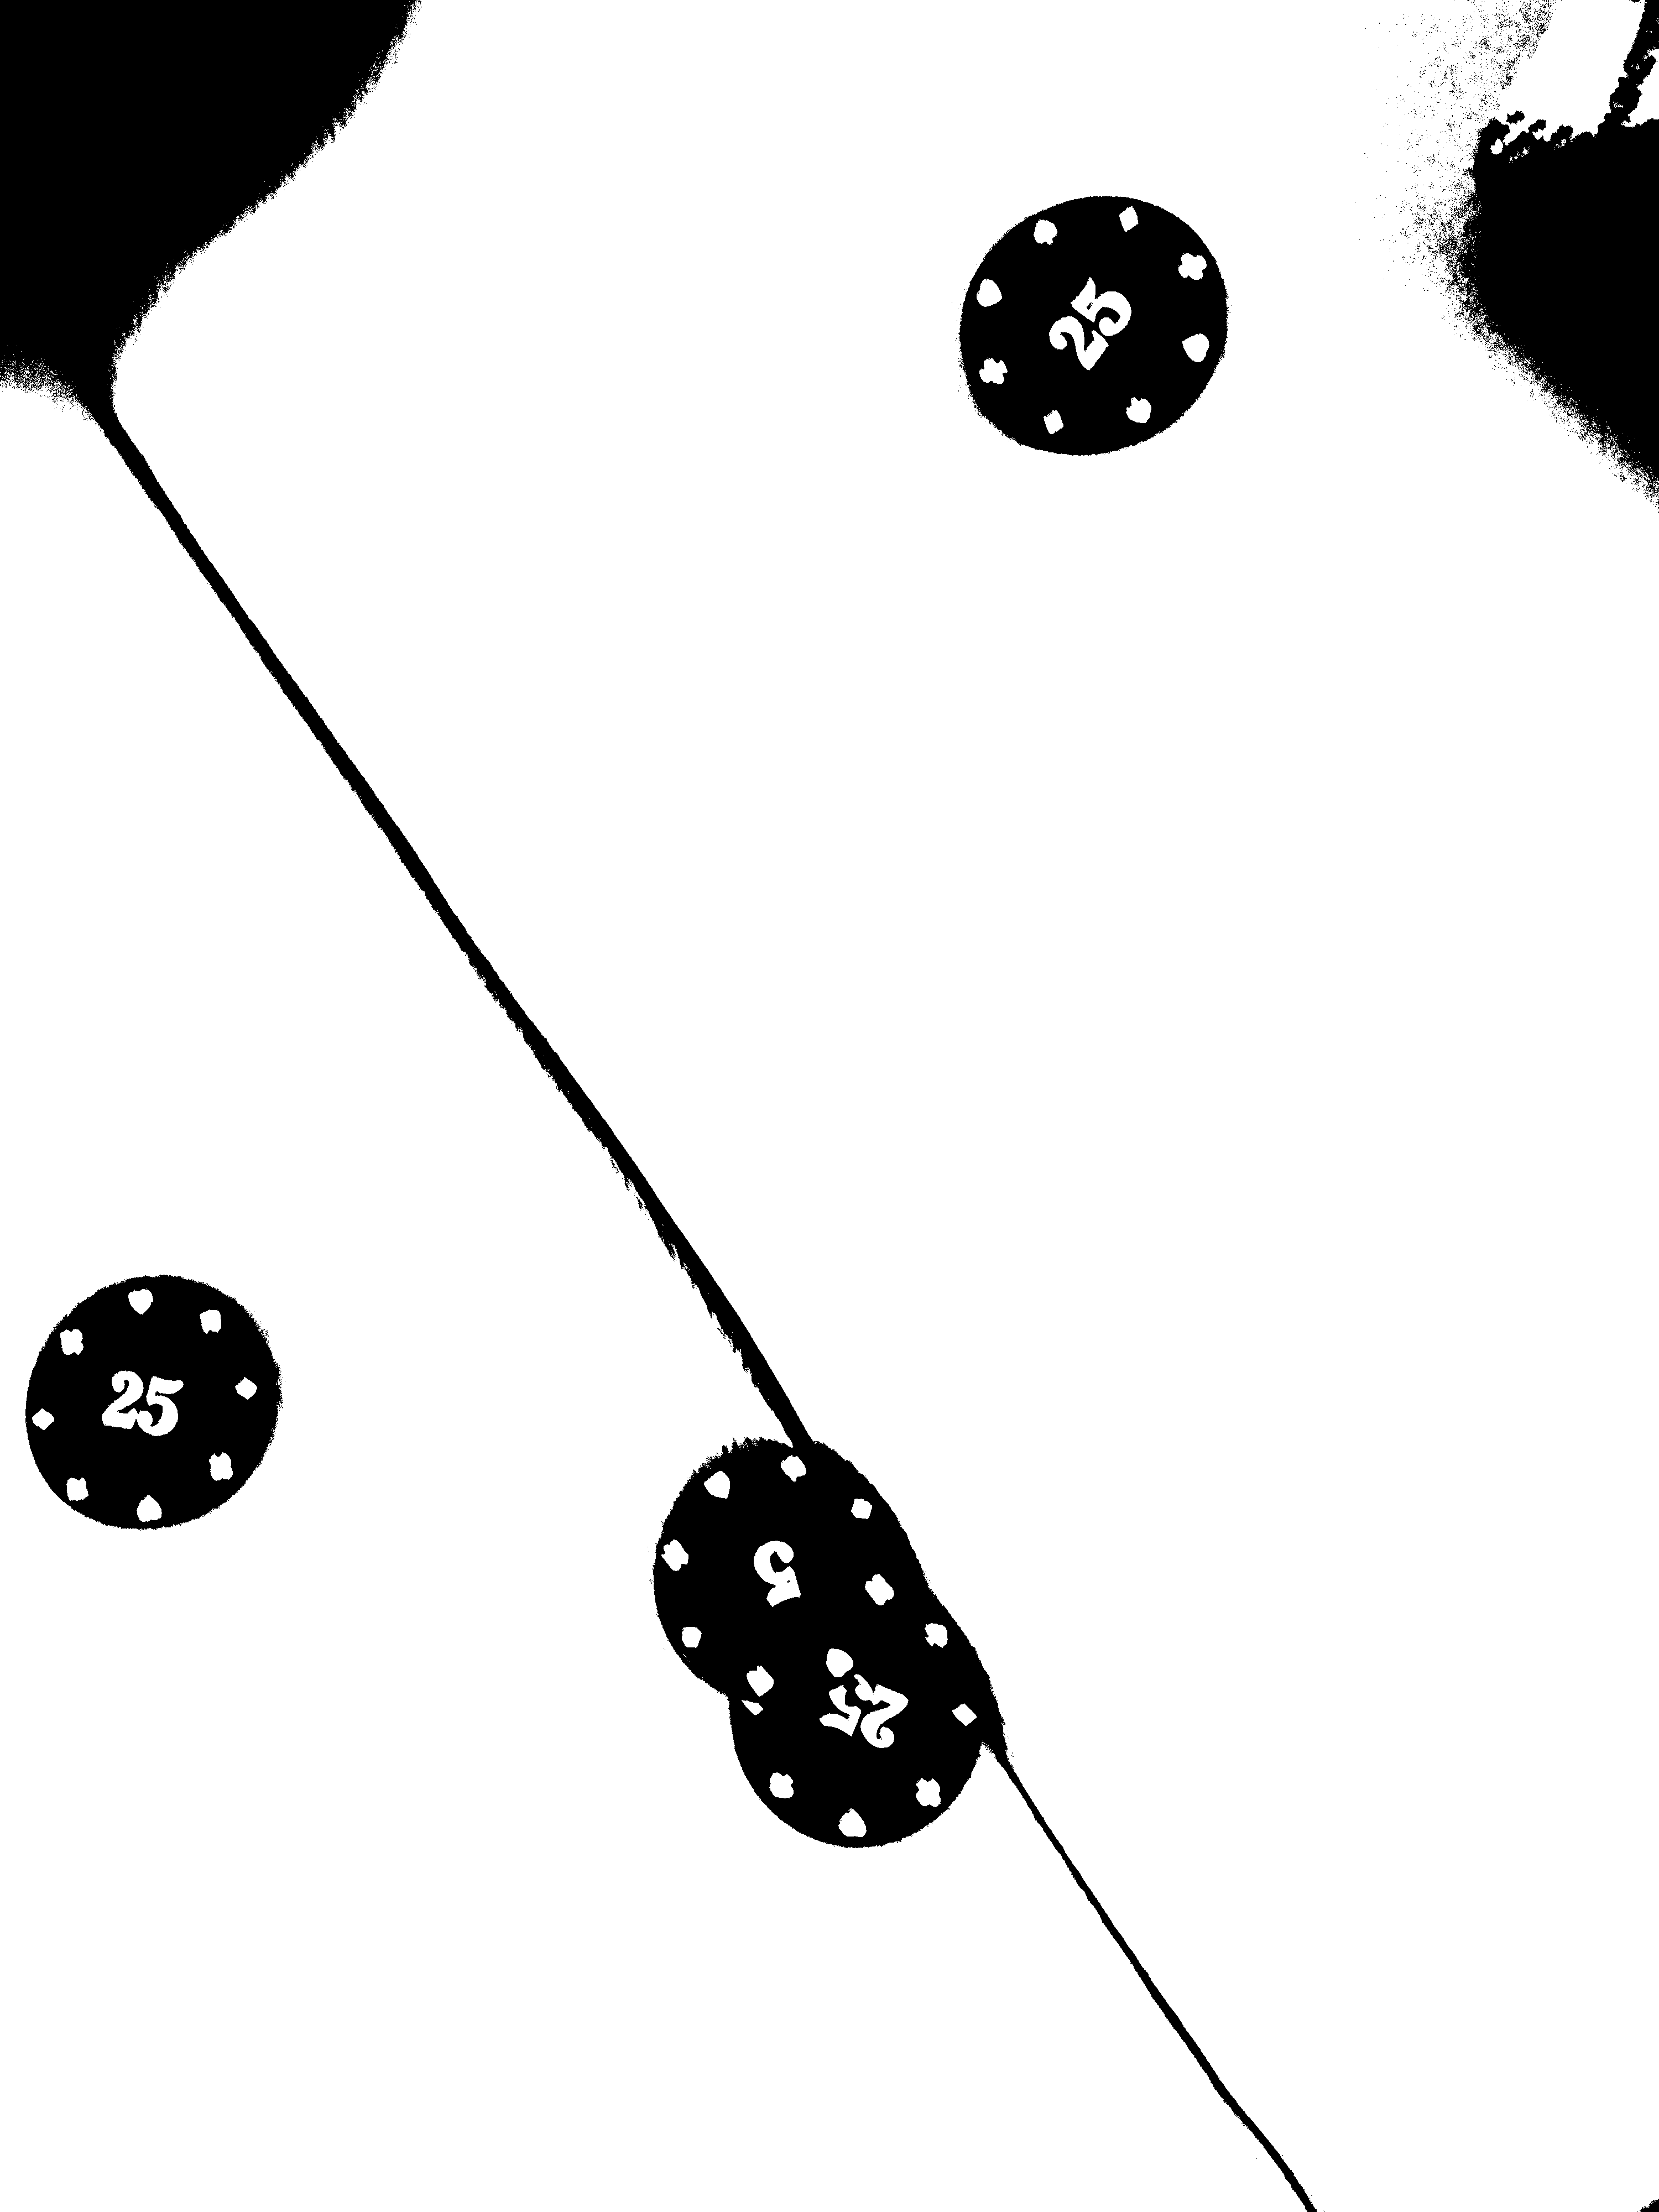

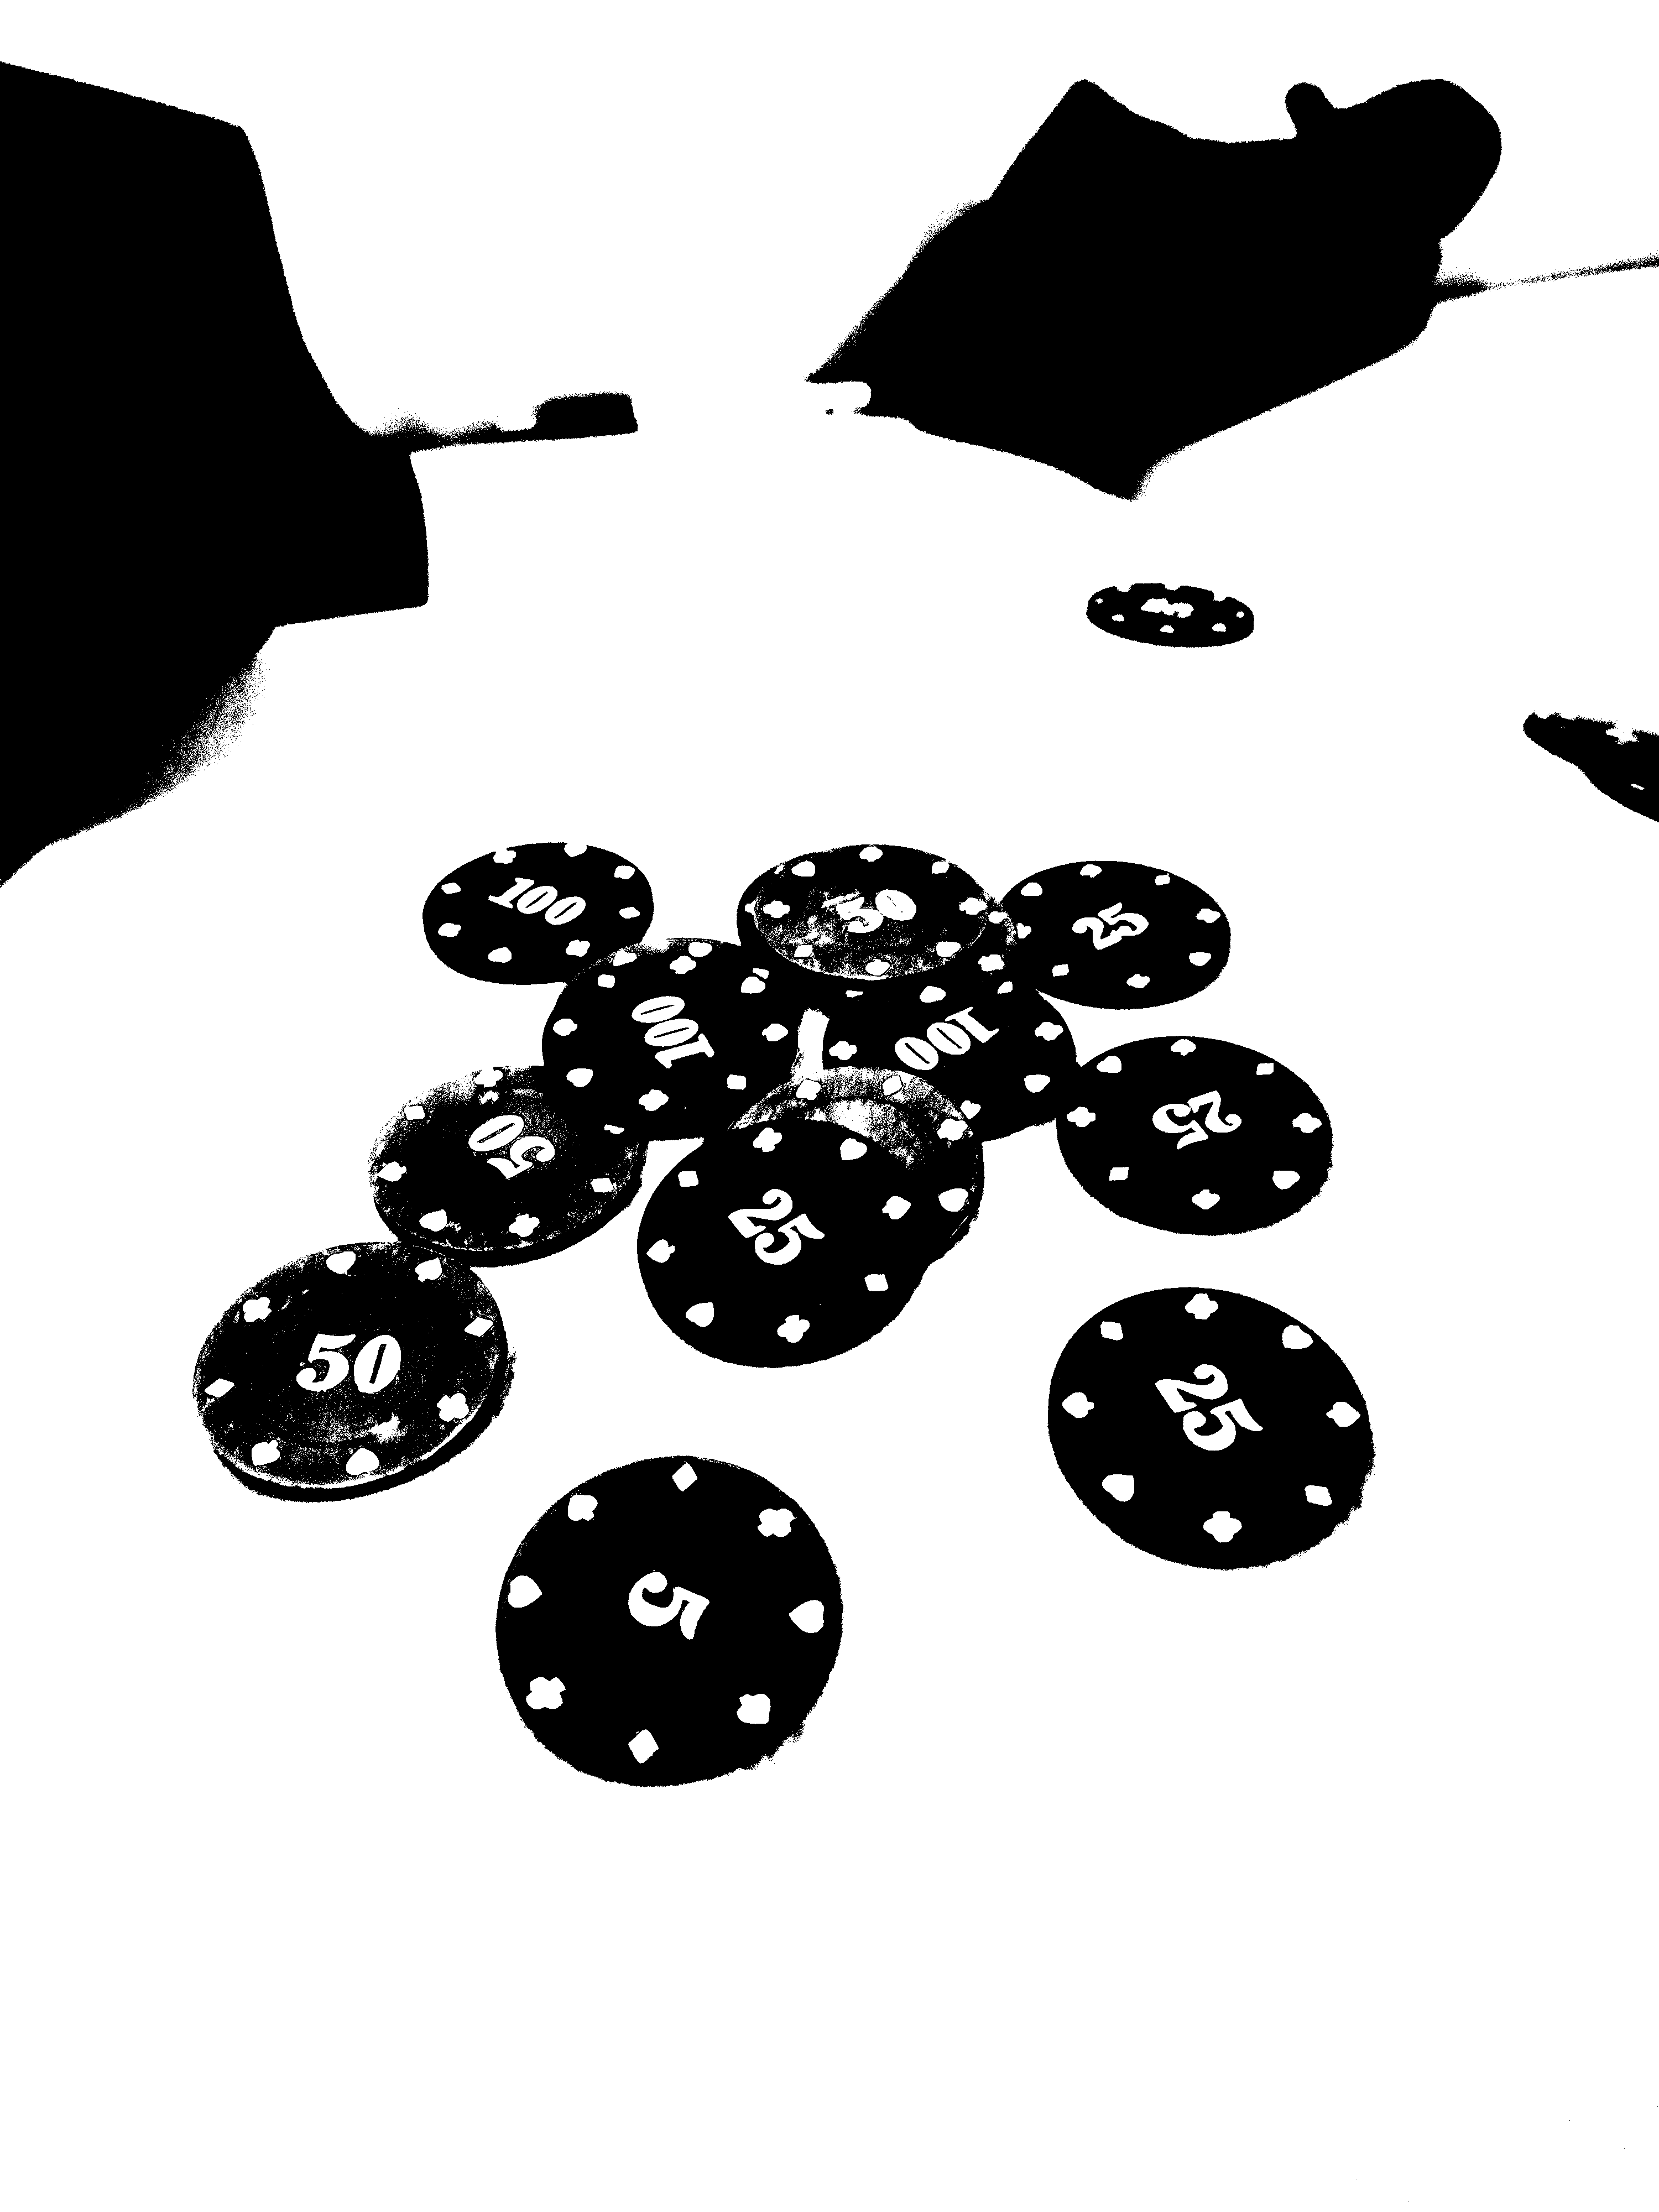

In [21]:
for file in glob.glob('./photos/circles/*.jpg'):
    circle_img = cv2.imread(file, cv2.IMREAD_COLOR)
    
#     dim = (608, 608)
#     circle_img = cv2.resize(circle_img, dim)
    
    circle_img = cv2.cvtColor(circle_img, cv2.COLOR_BGR2GRAY)
    
    circle_img = cv2.medianBlur(circle_img,1)
    
    circle_img = cv2.threshold(circle_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
#     circle_img = cv2.Canny(circle_img, 100, 200)
#     circle_img = cv2.cvtColor(circle_img, cv2.COLOR_BGR2GRAY)
    
    
    display(Image.fromarray(circle_img))
    str_ = pytesseract.image_to_string(circle_img)
#     print(str_)
#     break 

In [11]:
# for file in glob.glob('./circles/*.png'):
#     pass
# #     circle_img = cv2.imread(file, cv2.IMREAD_COLOR)
# #     display(Image.fromarray(circle_img))

In [12]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [13]:
img1 = glob.glob('./circles/*.png')[0]
img2 = glob.glob('./circles/*.png')[1]

img1 = cv2.imread(img1, cv2.IMREAD_COLOR)
# img1 = np.array(Image.open(img1))
img1 = cv2.resize(img1, None, fx=0.25, fy=0.25)

img2 = cv2.imread(img2, cv2.IMREAD_COLOR)
# img2 = cv2.resize(img2, None, fx=0.25, fy=0.25)

In [14]:
seq = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(
        scale=(0.5, 0.7)
    ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
])

scaleBg = iaa.Resize({"height": 608, "width": 608})

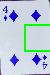

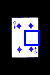

In [15]:
bbs = BoundingBoxesOnImage([
    BoundingBox(x1=25, y1=25, x2=50, y2=50),
    BoundingBox(x1=75, y1=75, x2=100, y2=100)
], shape=img1.shape)

img1_f = bbs.draw_on_image(img1, size=2)
display(Image.fromarray(img1_f))

img1_aug, bbs_aug = seq(image=img1, bounding_boxes=bbs)

img1_f = bbs_aug.draw_on_image(img1_aug, size=2, color=[0, 0, 255])
display(Image.fromarray(img1_f))

In [10]:
# https://stackoverflow.com/questions/14063070/overlay-a-smaller-image-on-a-larger-image-python-opencv
def overlay_image_alpha(img, img_overlay, x, y, alpha):
    """Overlay `img_overlay` onto `img` at (x, y) and blend using `alpha_mask`.

    `alpha_mask` must have same HxW as `img_overlay` and values in range [0, 1].
    """
    
    rgba = cv2.cvtColor(img_overlay, cv2.COLOR_BGR2BGRA)
    alpha_mask = rgba[:, :, 3] / 255.0 
    alpha_mask = alpha_mask - alpha
    img_overlay = rgba[:, :, :3]
    
    img = img[:, :, :3].copy()
    
    # Pass only copies!!!!!!!!!!!!!!!!!!
#     img = img.copy()
#     img_overlay = img_overlay.copy()
#     alpha_mask = alpha_mask.copy()
    
    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        print("XD")
        return

    # Blend overlay within the determined ranges
    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]
    alpha_inv = 1.0 - alpha
    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop
    return img

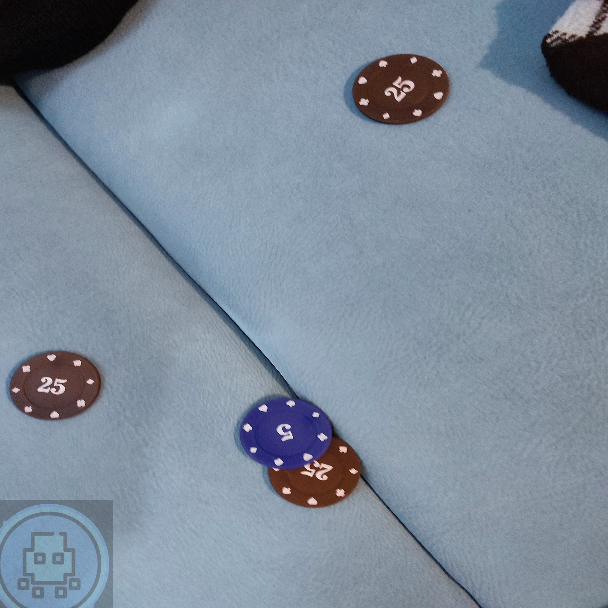

In [11]:
img2_f = scaleBg.augment_image(img2)

xd = overlay_image_alpha(img2_f, img1, -15, 500, 0.78)
display(Image.fromarray(xd))